In [10]:
# Import dependencies
import numpy as np
import pandas as pd
from neuralprophet import load, set_random_seed
from statsmodels.graphics.tsaplots import plot_pacf

# Set random seed
set_random_seed(0)

def preprocess_data():
    # Read data
    df = pd.read_csv('../data/full_dataset_15Min.csv', sep=';', index_col=0)

    # Retrieve index data and call "ds"
    df['ds'] = df.index

    # Remove index
    df.reset_index(drop=True, inplace=True)

    # Include aarhus data and ds columns
    df = df[['ds', 'Aarhus City Activity', "Middeltemperatur", "Aarhus City medlemmer", "Aarhus TOTAL medlemmer"]]

    # rename columns
    df = df.rename(columns={"Aarhus City Activity": "y"})

    # For Aarhus City, values before 22th of October are zero, so we remove them from the dataset
    # Loop through the rows, and return the index of the first row that contains a non zero value
    for i in range(len(df)):
        if df['y'].iloc[i] != 0:
            index = i
            break

    # Remove all rows before the first non zero value
    df = df.iloc[index:]

    # There is some corrupted data in the end, all values are zero. We find the spot where there are at least 300 zeros in a row, and remove all data after that.
    for i in range(len(df)):
        if sum(df['y'].iloc[i:i+300]) == 0:
            index = i
            break

    df = df.iloc[:index]

    # For some reason Neural Prophet does not like columns which are not either, 'y','ds' or a named regressor. Therefore, this fix is needed
    columnsToKeep = ['ds','y']
    regressorsList = ['Middeltemperatur'] # This is the list of regressors we want to keep.
    #regressorsList = ['Middeltemperatur', 'Aarhus City medlemmer', 'Aarhus TOTAL medlemmer'] # FULL LIST OF REGRESSORS

    # this removes all columns not 'ds','y' or any regressors
    df = df[df.columns.intersection(np.concatenate((columnsToKeep, regressorsList)))]

    return df

# Forecast_range
forecast_range = 4*24*7 # 1 week

def get_train_test_data(df):
    ####### SPLIT TO GET TEST SET ########
    # Isolate last week of data for testing, that is 4*24*7 = 672 rows
    df_test = df.iloc[-forecast_range:]

    # Remove the test set from the training set
    df = df.iloc[:-forecast_range]

    return df, df_test

def load_model():
    # Load model
    m = load("../output/model_1.np")

    return m


In [11]:
df = preprocess_data()
df, df_test = get_train_test_data(df)
m = load_model()

In [ ]:
def forecast(m, df, forecast_range):
    # Create a new dataframe reaching 672 into the future for our forecast, n_historic_predictions also shows historic data
    df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=forecast_range)

    # Predict the future
    forecast = m.predict(df_future)

    return forecast

forecast = forecast(m, df, forecast_range)

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 99.999% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view 

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/data/process.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/data/process.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_s

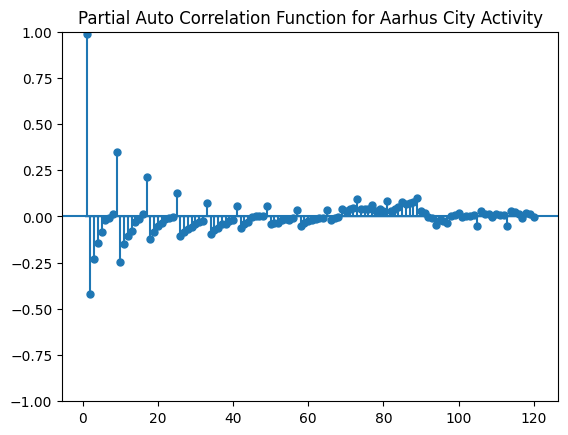

In [ ]:
########### PACF PLOT ############
plot = plot_pacf(df["y"],
          lags=120,
          method='ywm',
          zero=False,
          alpha=0.05,
          use_vlines=True, 
          title="Partial Auto Correlation Function for Aarhus City Activity")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/plot_model_parameters_matplotlib.py:561: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y["ds"].dt.to_pydatetime(),

WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/ne

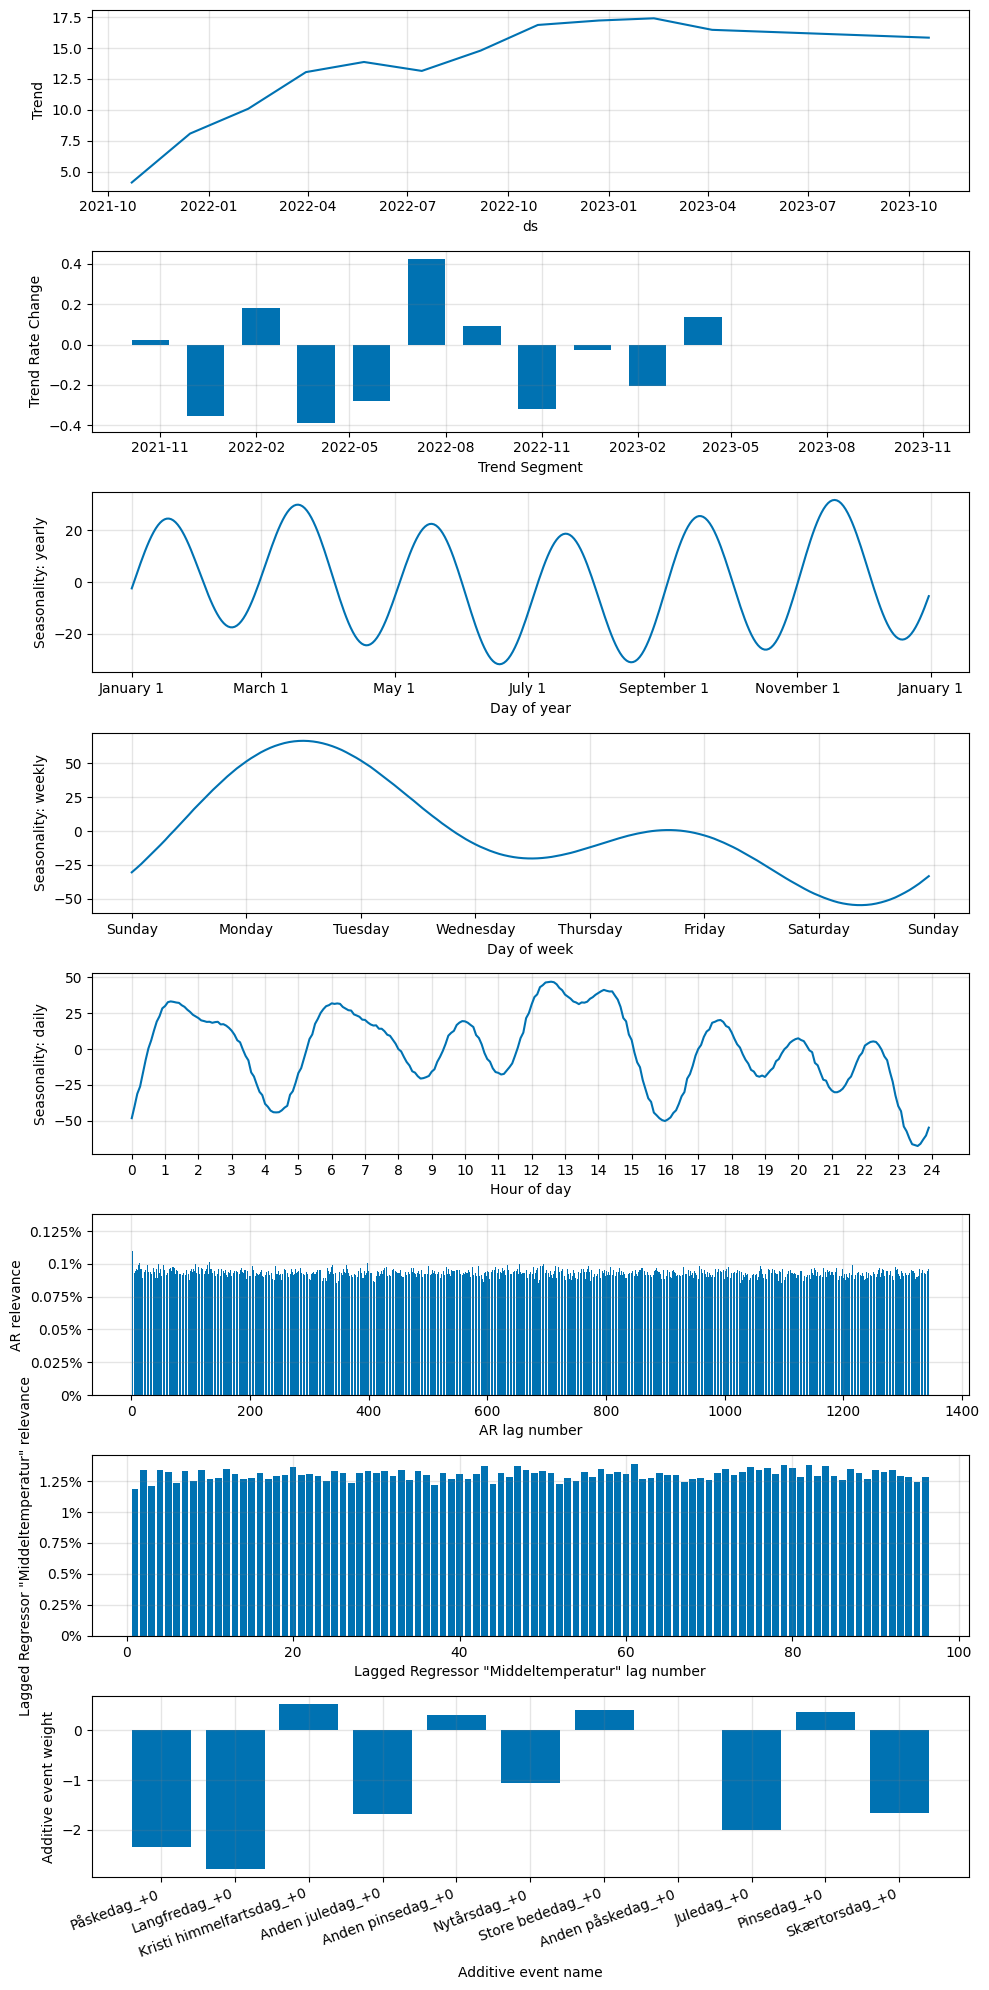

In [ ]:
############# PARAMETER PLOT ############
m.set_plotting_backend("matplotlib")
m.plot_parameters(figsize=(10,20))

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /home/aleksander/projects/boulders_data_science/venv/lib/python3.10/site-packages/neuralprophet/plot_forecast_matplotlib.py:300: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst["ds"].dt.to_pydatetime()



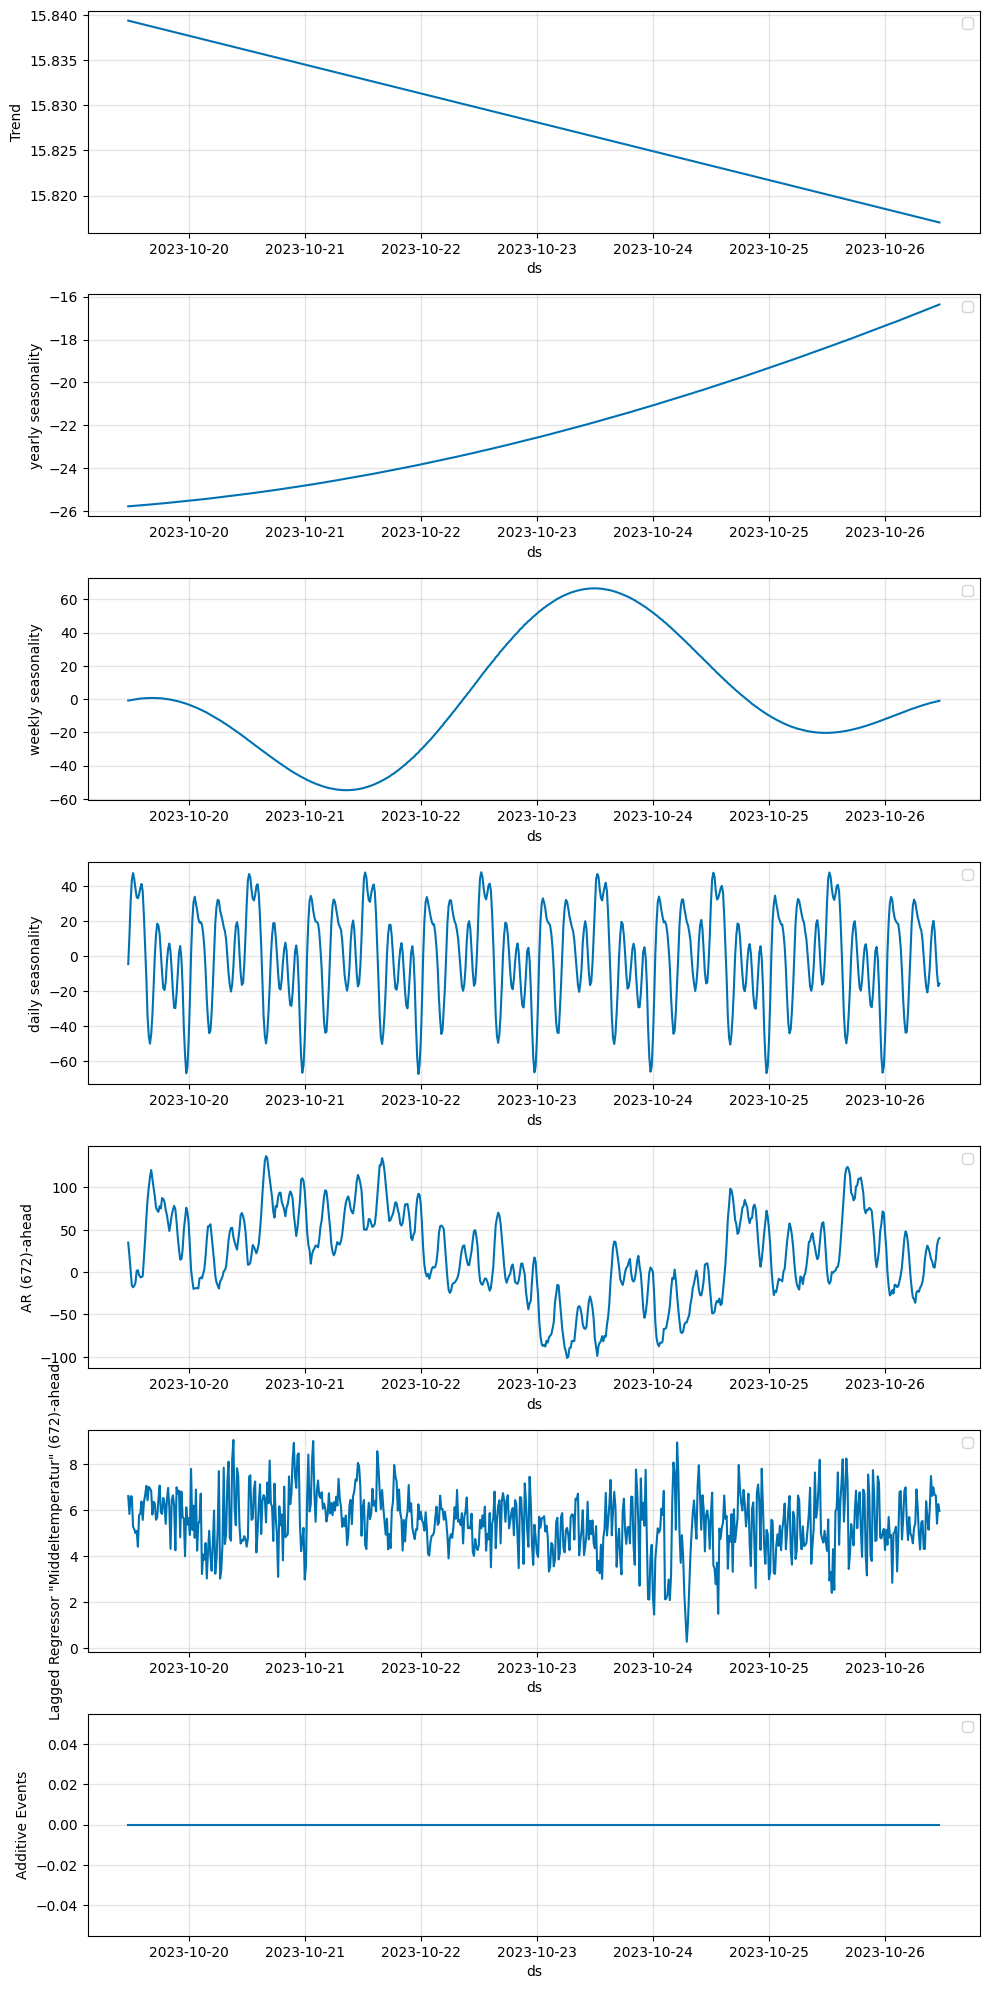

In [ ]:
############# COMPONENTS PLOT ############
m.set_plotting_backend("matplotlib")
m.plot_components(forecast[-672:], forecast_in_focus=672, figsize=(10,20))